<a href="https://colab.research.google.com/github/kmrasmussen/cell_project/blob/main/Section_3_1_Basic_Autencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class CellDataset(Dataset):
    def __init__(self, numpy_matrix):
        self.X = torch.from_numpy(numpy_matrix)
        self.n_genes = self.X.shape[1]
        # Library sizes for each cell
        self.cell_library_sizes = torch.sum(self.X, dim = 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return {'x': self.X[idx], 'l': self.cell_library_sizes[idx]}

class BasicAutoencoder(nn.Module):
    def __init__(self, n_genes, h_dim1, h_dim2,  z_dim):
        super(BasicAutoencoder, self).__init__()
        print(n_genes)
        # encoder layers
        self.encode1 = nn.Linear(n_genes, h_dim1)
        self.encode2 = nn.Linear(h_dim1, h_dim2)
        self.encode3 = nn.Linear(h_dim2, z_dim)
        # decoder layers
        self.decode1 = nn.Linear(z_dim, h_dim2)
        self.decode2 = nn.Linear(h_dim2, h_dim1)
        self.decode3 = nn.Linear(h_dim1, n_genes)
    
    def encode(self, x):
        x = F.relu(self.encode1(x))
        x = F.relu(self.encode2(x))
        x = self.encode3(x)
        return x
    
    def decode(self, x):
        x = F.relu(self.decode1(x))
        x = F.relu(self.decode2(x))
        x = self.decode3(x)
        return x
    
    def forward(self, x):
        return self.decode(self.encode(x))

# Data sets

In [ ]:
X = np.load('/content/gdrive/My Drive/uni_archive/cell/immune_control_subsampled_alone.npy')
GAUSS_SIM = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_difficult1.npy')
GAUSS_SIM_LABELS = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_labels2_difficult1.npy')

In [ ]:
dataset = CellDataset(X)

In [ ]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [9000, 3000, 1019]) # 9000, 3000, 1019

In [ ]:
minibatch_size = 32
train_loader = DataLoader(train_set, batch_size=minibatch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=minibatch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=minibatch_size, shuffle=True)

# Training

In [ ]:
def train(model, dataloader, optimizer, loss_function):
    model.train()
    running_loss = 0.0
    # Move through all the cells with minibatches
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()  
        # Get the cell counts
        net_input = data['x']
        # Autoencode
        net_output = model(net_input.float())
        # Compute loss difference between input cells and autoencoded cells
        loss = loss_function(net_input, net_output)
        # Backpropagate and adjust weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    training_loss = running_loss / len(dataloader.dataset)
    return training_loss

# Validate is same as train but without adjusting weights
def validate(model, dataloader, optimizer, loss_function):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            net_input = data['x']
            net_output = model(net_input.float())
            loss = loss_function(net_input, net_output)
            running_loss += loss.item()
        validation_loss = running_loss / len(dataloader.dataset)
        return validation_loss

In [ ]:
# Make autoencoder with desired architecture
net = BasicAutoencoder(dataset.n_genes, h_dim1 = 1000, h_dim2=200, z_dim=20)
loss_function = torch.nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

history_epochs = []
history_train = []
history_val = []
n_epochs = 10
# Train for a number of epochs
for epoch_i in range(n_epochs):
    print('Epoch', epoch_i)
    train_loss = train(net, train_loader, optimizer, loss_function)
    print('Train loss', train_loss)
    val_loss = validate(net, val_loader, optimizer, loss_function)
    print('Val loss', val_loss)
    history_epochs.append(epoch_i)
    history_train.append(train_loss)
    history_val.append(val_loss)
    
test_loss = validate(net, test_loader, optimizer, loss_function)
print('Test loss:', test_loss)

4000
Epoch 1
Train loss 20375.622361545138
Val loss 39592.47049283854
Epoch 2
Train loss 22799.67225434028
Val loss 41274.46894140625
Not better tha 39592.47049283854
Epoch 3
Train loss 22271.828688802085
Val loss 13095.043595052084
Epoch 4
Train loss 9995.516281358507
Val loss 36207.12515755208
Not better tha 13095.043595052084
Epoch 5
Train loss 10954.14424435764
Val loss 2632.415803385417
Epoch 6
Train loss 2363.1876685112848
Val loss 1975.965953125
Epoch 7
Train loss 1896.8291146918402
Val loss 1824.0576126302083
Epoch 8
Train loss 2135.6446526692707
Val loss 1951.6511910807292
Not better tha 1824.0576126302083
Epoch 9
Train loss 1734.5162915039064
Val loss 1806.5050387369793
Epoch 10
Train loss 8890.695299913194
Val loss 2639.805196614583
Not better tha 1806.5050387369793
Test loss: 2023.7458656618007


# History

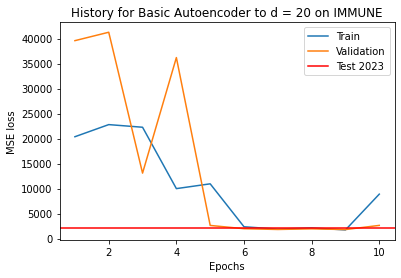

In [ ]:
plt.ylabel('MSE loss')
plt.xlabel('Epochs')
plt.title('History for Basic Autoencoder to d = 20 on IMMUNE')
plt.plot(history_epochs,history_train, label='Train')
plt.plot(history_epochs,history_val, label='Validation')
plt.axhline(y=test_loss, color='r', linestyle='-', label='Test ' + str(int(test_loss)))
plt.legend()

# Scatter plots of cells

In [ ]:
X_encoded = net.encode(torch.tensor(X).float()).detach()

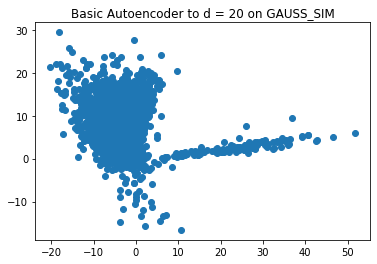

In [ ]:
plt.title('Basic Autoencoder to d = 20 on GAUSS_SIM')
plt.scatter(X_encoded[:,0], X_encoded[:,1])
#plt.scatter(X_encoded[:7000][:,0], X_encoded[:7000][:,1], c=GAUSS_SIM_LABELS[:7000], marker='o', s=10, alpha=0.4)
#plt.scatter(X_encoded[7000:][:,0], X_encoded[7000:][:,1], c=GAUSS_SIM_LABELS[7000:], marker='^', s=10, alpha=0.4)
#plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Colab Cell Experiments/plots/exp.2.1.gauss_sim_basicautoencoder_d2_plot.png')

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_encoded)
print('Explained variance ratios', pca.explained_variance_ratio_)
X_encoded_pca = pca.transform(X_encoded)

Explained variance ratios [0.6785199  0.20293801]


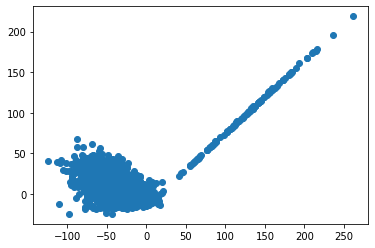

In [ ]:
plt.scatter(X_encoded_pca[:,0], X_encoded_pca[:,1])

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()
X_encoded_umap = reducer.fit_transform(X_encoded)

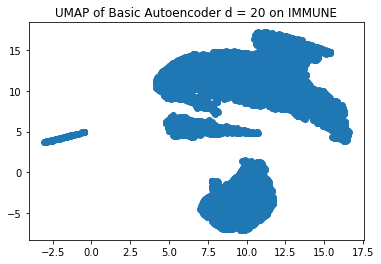

In [ ]:
plt.title('UMAP of Basic Autoencoder d = 20 on IMMUNE')
plt.scatter(X_encoded_umap[:,0], X_encoded_umap[:,1])
#plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Colab Cell Experiments/plots/exp.2.1_basic_autoencoder_d20_umap_b.png')